In [397]:
import os # operating system module for accessing environment variables
from dotenv import load_dotenv # loads environment variables from .env file
from lyricsgenius import Genius # imports the LyricsGenius library which is a wrapper for the Genius 
import spotipy # spotipy library makes Spotify API easier to use
from spotipy.oauth2 import SpotifyClientCredentials # imports the authentication we neeed for spotify 
import nltk # natural language toolkit, an NLP library for text processing
from nltk.sentiment.vader import SentimentIntensityAnalyzer # imports the vader sentiment analyzer from nltk
import matplotlib.pyplot as plt # for creating plots and visualizations

In [399]:
load_dotenv("3510.env") # loads our Genius access token from the 3510.env file
# create the authentication manager using our Spotify client ID and secret from the .env file
clientCredentialManager = SpotifyClientCredentials(
    client_id=os.getenv("SPOTIFY_CLIENT_ID"), # gets the client ID from environment variables
    client_secret=os.getenv("SPOTIFY_CLIENT_SECRET") # gets the client secret from environment variables
)

# create the Spotify API client object that we'll use to make all our Spotify requests
sp = spotipy.Spotify(client_credentials_manager=clientCredentialManager) # this sp object lets us search artists, get tracks, etc.
nltk.download("vader_lexicon", quiet=True) # downloads the vader dictionary of words and their sentiment scores, quiet=True suppresses the download messages

# Initialize the vader sentiment analyzer
vaderSIA = SentimentIntensityAnalyzer() # creates the sentiment analyzer object that we'll use to analyze text

In [7]:
genius = Genius(os.getenv("GENIUS_CLIENT_ACCESS_TOKEN")) # creates the Genius API client object using our access token 

In [9]:
genius.excluded_terms = ["(Remix)", "(Live)"] # tells Genius to skip songs with these terms in the title, so we get original versions

In [11]:
genius.remove_section_headers = True # removes the [Chorus], [Verse 1] tags from lyrics to make them cleaner for analysis

In [27]:
def searchByLyrics(lyricSnippet, maxResults=5): # defines function that takes a lyric snippet and optional max results (default is 5)

    # From documentation: https://lyricsgenius.readthedocs.io/en/master/examples/snippets.html#searching-for-a-song-by-lyrics
    # Example usage:
    # request = genius.search_lyrics('Jeremy can we talk a minute?')
    # for hit in request['sections'][0]['hits']:
    #     print(hit['result']['title'])
    
    request = genius.search_lyrics(lyricSnippet) # searches Genius for songs containing the lyric snippet, returns a complex nested dictionary
    
    # Check if we got anything back
    if not request: # checks if request is None or empty (search failed)
        return None # returns None to indicate no results
    
    songs = [] # creates empty list to store the song results
    
    # Loop through results (if the structure is wrong, this will just fail and we return None)
    for hit in request['sections'][0]['hits'][:maxResults]: # navigates to the hits list in the response, [:maxResults] slices to only get first 5 results
        title = hit['result']['title'] # extracts the song title from the nested dictionary
        artist = hit['result']['primary_artist']['name'] # navigates through the dict to get the artist name
        songs.append((title, artist)) # creates a tuple with title and artist, adds it to the songs list
    
    # Return songs if we found any, otherwise None
    if songs: # checks if the songs list has any items in it
        return songs # returns the list of tuples
    else: # if the list is empty
        return None # returns None to indicate no results found

In [29]:
searchByLyrics("more than a feeling")

[('More Than a Feeling', 'Boston'),
 ('The Power of Love', 'Huey Lewis & The News'),
 ('Better Than Words', 'One Direction'),
 ('Kinda Like a Big Deal', 'Clipse'),
 ('Zeal', 'The Belonging Co')]

In [31]:
searchByLyrics("i dont even know my name anymore")

[('ATF Radio Freestyle', 'Drake'),
 ('Thinking Bout You', 'Nick De La Hoyde'),
 ('Lemme Talk', 'Miraa May'),
 ('Darkness', 'Kidd Tha Rapper'),
 ('Vibbbee', 'Mike Dreams')]

In [32]:
searchByLyrics("im scared to love you darling", maxResults=10)

[('Snake With a Bone', 'Day We Ran'),
 ('Don’t Wake Me', 'Lightnin’ Hopkins'),
 ('I Only Like His Hat, Not Him', 'Florence Clementine'),
 ('Now or Never', 'David Bayu'),
 ('Papa', 'Scott Helman'),
 ('Quicksand', 'SZA'),
 ('Wrong Number', 'Aaron Neville'),
 ('Wrong Number (I’m Sorry, Goodbye)', 'Aaron Neville'),
 ('u always saw the best in me', 'Okay Alright'),
 ('Letter To Agony', 'Ben Kweller')]

In [36]:
def getLyrics(artistName, songTitle): # defines function that takes artist name and song title as inputs
   
    song = genius.search_song(songTitle, artistName) # searches Genius for the song, returns a song object or None if not found
    
    if song: # checks if a song was found (song will be None if not found)
        return song.lyrics # returns the lyrics as a string from the song object
    else: # if no song was found
        return None # returns None so we can handle this error in the main bot file

In [405]:
getLyrics("Drake", "Look What Youve Done")

Searching for "Look What Youve Done" by Drake...
Done.


"Yeah\nYeah\nMan\n\nIt's like '09 in your basement and I'm in love with Nebby\nAnd I still love her, but it fell through because I wasn't ready\nAnd your back hurt, and your neck hurt and you smokin' heavy\nAnd I sit next to you, and I lecture you because those are deadly\nAnd then you ash it, and we argue about spendin' money on bullshit\nAnd you tell me I'm just like my father, my one button, you push it\nNow it's fuck you, I hate you, I'll move out in a heartbeat\nAnd I leave out and you call me and you tell me that you sorry\nAnd you love me and I love you and your heart hurts, mine does too\nAnd it's just words and they cut deep, but it's our world, it's just us two\nI see painkillers on the kitchen counter, I hate to see it all hurt so bad\nBut maybe I wouldn't have worked this hard if you were healthy and it weren't so bad, uh\nMaybe I should walk up the street\nAnd try and get a job at the bank\n'Cause leave it up to me, J, and Neeks\nWe'll probably end up robbin' a bank\nThen 

In [406]:
lyrics = getLyrics("Drake", "Look What Youve Done")

Searching for "Look What Youve Done" by Drake...
Done.


In [44]:
# make a function to get the top 10 songs from an artist. 
def getTopTracks(artistName): # defines a function that takes an artist name as input
    # get the top tracks for a given artist name
    # returns a set of tuples containing the track name, album name, and the popularity
    # search for the artist
    results = sp.search(q=artistName, type='artist', limit=1) # searches Spotify for the artist, q is the query, type='artist' means only search for artists not songs, limit=1 returns only the best match
    
    # now check if the artist was found
    if not results['artists']['items']: # results['artists']['items'] is a list, if it's empty that means no artist was found
        return None # returns None so we can check for this error in the main bot file
    
    # this is how we get the artist id which is needed to ask for the top 10 songs, and since its a bot
    # having this in the function is necessary since i dont just have a database of all artists ID somewhere. 
    # we have to find a way to search for it and how i did that in project 1 as well as in class notes is we have to 
    # sift through the disctionary to get the ID since the only other way is to manually go to the artist's spotify
    # url and grab it from the end but idk how to do that and this works so here we go
    artistID = results['artists']['items'][0]['id'] # navigates through the nested dictionary: results is a dict, ['artists'] gets the artists section, ['items'] gets the list of artists, [0] gets the first artist, ['id'] gets their unique Spotify ID
    artistActualName = results['artists']['items'][0]['name'] # this is so that it gives us the spotify name, which is cleaner than
    # a name just written in whatever way like "macmiller" or "MACMILLER" or "mac Miller"... it just returns whatever name is in that 
    # spotify artists dictionary, ideally "Mac Miller"
    # Get top tracks
    # this literally just takes the ID we just got and named "artistID" and fetches the top 10 songs which is what spotify
    # artist_top_tracks does. we dont need to specify anywhere for only 10 becuase this only gives us the top 10. 
    topTracks = sp.artist_top_tracks(artistID, country='US') # calls the Spotify API method to get top tracks for this artist ID, US so it gives us US popularity rankings
    tracks = topTracks['tracks'] # and here we are naming the top tracks that we retrieved as tracks to give us just the tracks list from the response dictionary
    
    # create set to store track data which will contain tuples... this is just like in Dr. Zietz's reverb helper functions py file 
    setOfTrackData = set() # creates an empty set to store our track information, sets automatically remove duplicates
    
    # Now we are looping through each track in the tracks list and for each track, we are taking out the track name, album name, 
    # and the popularity and bundling those things into a tuple. 
    for track in tracks: # loops through each track in the tracks list (up to 10 tracks)
        trackName = track['name'] # extracts the track name from the track dictionary
        albumName = track['album']['name'] # navigates through track dictionary to get album name (track['album'] is another dict, then ['name'] gets the album name)
        popularity = track['popularity'] # extracts the popularity score (0-100)
        
        trackDataTuple = (trackName, albumName, popularity) # here is the tuple we will be bundling up and storing in the setOfTrackData set, parentheses create a tuple
        setOfTrackData.add(trackDataTuple) # here is where we add it, .add() is the method for adding items to a set
    
    return setOfTrackData, artistActualName # returns two things: the set of track data and the artist actual name that we got earlier in the code, this is called tuple unpacking

In [52]:
getTopTracks("Drake")

({('DIE TRYING', '$ome $exy $ongs 4 U', 83),
  ("God's Plan", 'Scorpion', 85),
  ('Headlines', 'Take Care (Deluxe)', 87),
  ('NOKIA', '$ome $exy $ongs 4 U', 86),
  ('Not You Too (feat. Chris Brown)', 'Dark Lane Demo Tapes', 85),
  ('One Dance', 'Views', 90),
  ('Passionfruit', 'More Life', 87),
  ('She Will', 'Tha Carter IV (Complete Edition)', 79),
  ('WAIT FOR U (feat. Drake & Tems)', 'I NEVER LIKED YOU', 84),
  ('Which One (feat. Central Cee)', 'Which One', 83)},
 'Drake')

In [54]:
getTopTracks("Bon Iver")

({('Beach Baby', 'Blood Bank', 71),
  ('Boys Of Faith (feat. Bon Iver)', 'Boys Of Faith (feat. Bon Iver)', 67),
  ('For Emma', 'For Emma, Forever Ago', 72),
  ('Holocene', 'Bon Iver, Bon Iver', 71),
  ('Re: Stacks', 'For Emma, Forever Ago', 68),
  ('Rosyln',
   'The Twilight Saga: New Moon (Original Motion Picture Soundtrack)',
   77),
  ('Skinny Love', 'For Emma, Forever Ago', 75),
  ('Wash.', 'Bon Iver, Bon Iver', 72),
  ('evermore (feat. Bon Iver)', 'evermore', 65),
  ('exile (feat. Bon Iver)', 'folklore', 81)},
 'Bon Iver')

In [86]:
args = ("Bon", "Iver")

In [92]:
artistName = " ".join(args)

In [100]:
print(artistName)

Bon Iver


In [102]:
result = getTopTracks(artistName)

In [104]:
result

({('Beach Baby', 'Blood Bank', 71),
  ('Boys Of Faith (feat. Bon Iver)', 'Boys Of Faith (feat. Bon Iver)', 67),
  ('For Emma', 'For Emma, Forever Ago', 72),
  ('Holocene', 'Bon Iver, Bon Iver', 71),
  ('Re: Stacks', 'For Emma, Forever Ago', 68),
  ('Rosyln',
   'The Twilight Saga: New Moon (Original Motion Picture Soundtrack)',
   77),
  ('Skinny Love', 'For Emma, Forever Ago', 75),
  ('Wash.', 'Bon Iver, Bon Iver', 72),
  ('evermore (feat. Bon Iver)', 'evermore', 65),
  ('exile (feat. Bon Iver)', 'folklore', 81)},
 'Bon Iver')

In [267]:
args2 = ("Ponk", "Floid")

In [269]:
artistName = " ".join(args2)

In [271]:
artistName

'Ponk Floid'

In [273]:
result = getTopTracks(artistName)

In [274]:
if result is None:
    print((f"Could not find artist: {artistName}"))

In [275]:
result

({('Another Brick in the Wall, Pt. 2', 'The Wall', 81),
  ('Breathe (In the Air)', 'The Dark Side of the Moon', 80),
  ('Comfortably Numb', 'The Wall', 81),
  ('Have a Cigar', 'Wish You Were Here', 74),
  ('Hey You', 'The Wall', 75),
  ('Money', 'The Dark Side of the Moon', 76),
  ('Shine On You Crazy Diamond (Pts. 1-5)', 'Wish You Were Here', 73),
  ('The Great Gig in the Sky', 'The Dark Side of the Moon', 77),
  ('Time', 'The Dark Side of the Moon', 77),
  ('Wish You Were Here', 'Wish You Were Here', 83)},
 'Pink Floyd')

In [279]:
#so this might be unncessary because everything I try to put in to get it wrong and return none isnt working
#keep it anyway??

In [281]:
trackData, artistActualName = result

In [285]:
artistActualName

'Pink Floyd'

In [287]:
trackData

{('Another Brick in the Wall, Pt. 2', 'The Wall', 81),
 ('Breathe (In the Air)', 'The Dark Side of the Moon', 80),
 ('Comfortably Numb', 'The Wall', 81),
 ('Have a Cigar', 'Wish You Were Here', 74),
 ('Hey You', 'The Wall', 75),
 ('Money', 'The Dark Side of the Moon', 76),
 ('Shine On You Crazy Diamond (Pts. 1-5)', 'Wish You Were Here', 73),
 ('The Great Gig in the Sky', 'The Dark Side of the Moon', 77),
 ('Time', 'The Dark Side of the Moon', 77),
 ('Wish You Were Here', 'Wish You Were Here', 83)}

In [291]:
message = f"Top Tracks by {artistActualName}\n\n"

In [293]:
message

'Top Tracks by Pink Floyd\n\n'

In [297]:
sortedTracks = sorted(trackData, key=lambda x: x[2], reverse=True)
# lambda function says "for each item x, look at x[2]" and in this case we are sorting the
#tracks by x[2] which is popularity score! the reverse True makes the highest scores go first (most popularrrr) 

In [299]:
sortedTracks

[('Wish You Were Here', 'Wish You Were Here', 83),
 ('Comfortably Numb', 'The Wall', 81),
 ('Another Brick in the Wall, Pt. 2', 'The Wall', 81),
 ('Breathe (In the Air)', 'The Dark Side of the Moon', 80),
 ('Time', 'The Dark Side of the Moon', 77),
 ('The Great Gig in the Sky', 'The Dark Side of the Moon', 77),
 ('Money', 'The Dark Side of the Moon', 76),
 ('Hey You', 'The Wall', 75),
 ('Have a Cigar', 'Wish You Were Here', 74),
 ('Shine On You Crazy Diamond (Pts. 1-5)', 'Wish You Were Here', 73)]

In [301]:
for i, (trackName, albumName, popularity) in enumerate(sortedTracks, 1): # enumerate gives us both the index (starting at 1), and the tuple
        message += f"{i}. {trackName} - {albumName} (Popularity: {popularity})\n" # adds each track to the message with formatting

In [303]:
message

'Top Tracks by Pink Floyd\n\n1. Wish You Were Here - Wish You Were Here (Popularity: 83)\n2. Comfortably Numb - The Wall (Popularity: 81)\n3. Another Brick in the Wall, Pt. 2 - The Wall (Popularity: 81)\n4. Breathe (In the Air) - The Dark Side of the Moon (Popularity: 80)\n5. Time - The Dark Side of the Moon (Popularity: 77)\n6. The Great Gig in the Sky - The Dark Side of the Moon (Popularity: 77)\n7. Money - The Dark Side of the Moon (Popularity: 76)\n8. Hey You - The Wall (Popularity: 75)\n9. Have a Cigar - Wish You Were Here (Popularity: 74)\n10. Shine On You Crazy Diamond (Pts. 1-5) - Wish You Were Here (Popularity: 73)\n'

In [315]:
args = ("way", "down", "yonder", "by", "the", "chattahoochee")

In [317]:
lyricSnippet = " ".join(args)

In [319]:
lyricSnippet

'way down yonder by the chattahoochee'

In [327]:
args2 = ("")

In [331]:
lyricSnippet = " ".join(args2)

In [333]:
if not lyricSnippet:
    print("Please provide a lyric snippet to search for. Example: /searchlyrics Jeremy can we talk a minute")

Please provide a lyric snippet to search for. Example: /searchlyrics Jeremy can we talk a minute


In [337]:
args = ("way", "down", "yonder", "by", "the", "chattahoochee")

In [339]:
lyricSnippet = " ".join(args)

In [341]:
lyricSnippet

'way down yonder by the chattahoochee'

In [343]:
results = searchByLyrics(lyricSnippet, maxResults=5)

In [345]:
results

[('Chattahoochee', 'Alan Jackson'),
 ('Chattahoochee (Extended Mix)', 'Alan Jackson'),
 ('Chattahoochee (Extended Mix 2)', 'Alan Jackson'),
 ('Chattahoochee', 'Sammy SlamDance'),
 ('Finnegans Wake (Chap. 1.8)', 'James Joyce')]

In [347]:
#YAAAASSS

In [357]:
if results:
    message = f"Found {len(results)} song with those lyrics:\n\n"

    for i, (songTitle, artistName) in enumerate(results, 1): # enumerate gives us counter starting at 1, unpacks each tuple
            message += f"{i}. {songTitle} by {artistName}\n" # adds formatted line for each song. f strings vs. old string concatenation 
    message += f"\nUse /lyrics [artist] [song title] to see full lyrics!" # adds helpful tip at the end
    print(message)

Found 5 song with those lyrics:

1. Chattahoochee by Alan Jackson
2. Chattahoochee (Extended Mix) by Alan Jackson
3. Chattahoochee (Extended Mix 2) by Alan Jackson
4. Chattahoochee by Sammy SlamDance
5. Finnegans Wake (Chap. 1.8) by James Joyce

Use /lyrics [artist] [song title] to see full lyrics!


In [359]:
# async def lyrics(ctx, *args): # *args captures all words after /lyrics
args = ("bon", "Iver", "+", "beach", "baby")

In [361]:
fullInput = " ".join(args)

In [363]:
fullInput

'bon Iver + beach baby'

In [367]:
parts = fullInput.split("+")

In [369]:
parts

['bon Iver ', ' beach baby']

In [371]:
artistName = parts[0].strip()

In [373]:
artistName

'bon Iver'

In [375]:
songTitle = parts[1].strip()

In [377]:
songTitle

'beach baby'

In [383]:
print(f"Searching for lyrics to '{songTitle}' by {artistName}...")

Searching for lyrics to 'beach baby' by bon Iver...


In [385]:
getLyrics(artistName, songTitle)

Searching for "beach baby" by bon Iver...
Done.


"When you're out, tell your lucky one\nTo know that you'll leave\nDon't you lock when you're fleeing\nI'd like not to hear keys\nOnly hold till your coffee warms\nBut don't hurry and speed\nOnce a time, put a tongue\nIn your ear on the beach\nAnd you clutched kicking heels"

In [389]:
args2= ("kings", "of", "Leon", "arizona")

In [391]:
fullInput = " ".join(args2)

In [393]:
fullInput

'kings of Leon arizona'

In [395]:
if "+" not in fullInput: # checks if the user included the "+" separator we need
        print("Please use format: /lyrics [artist] + [song title]\nExample: /lyrics Post Malone + Circles")

Please use format: /lyrics [artist] + [song title]
Example: /lyrics Post Malone + Circles


In [428]:
def analyzeLyrics(lyrics, chunkSize=10): # defines function that takes lyrics and optional chunk size which ive set to 10

    # Check if lyrics exist
    if not lyrics: # checks if lyrics is None or empty string
        return None # returns None so we can handle this error in the main bot file
    
    # split lyrics into words
    words = lyrics.split() # splits the lyrics string into a list of words using spaces as the delimiter
    
    # if there are fewer words than chunk size, just analyze the whole thing
    if len(words) <= chunkSize: # if the song has 10 or fewer words, no need to chunk it
        overallScores = vaderSIA.polarity_scores(lyrics) # analyzes the entire lyrics at once, returns a dict with neg, neu, pos, and compound scores
        return { # returns a dictionary with the results
            'chunkScores': [overallScores], # puts the single score in a list for consistency with the multi-chunk format
            'chunks': [lyrics], # puts the entire lyrics in a list
            'averageCompound': overallScores['compound'] # the compound score is already the overall score since there's only one chunk
        }
    
    # initialize lists to store chunk data
    chunkScores = [] # creates empty list to store sentiment scores for each chunk
    chunks = [] # creates empty list to store the actual text of each chunk
    
    # break lyrics into chunks
    for i in range(0, len(words), chunkSize): # loops through words in steps of 10, so i=0, 10, 20, 30, etc.
        # Get the next chunk of words
        chunk = " ".join(words[i:i + chunkSize]) # takes a slice of 10 words starting at position i and joins them back into a string
        
        # get sentiment scores for this chunk
        scores = vaderSIA.polarity_scores(chunk) # analyzes sentiment of this 10 word chunk, returns dict like {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.4}
        
        # store the chunk and its scores
        chunks.append(chunk) # adds the chunk text to our chunks list
        chunkScores.append(scores) # adds the sentiment scores to our chunkScores list
    
    # calculate average compound score across all chunks
    compoundScores = [score['compound'] for score in chunkScores] # list comprehension that extracts just the compound score from each chunk's score dictionary
    averageCompound = sum(compoundScores) / len(compoundScores) # calculates the average by adding all compound scores and dividing by the number of chunks
    
    return { # returns a dictionary with all the analysis results
        'chunkScores': chunkScores, # list of all the score dictionaries
        'chunks': chunks, # list of all the text chunks
        'averageCompound': averageCompound # the average compound score for the whole song
    }


In [438]:
analyzeLyrics(lyrics, chunkSize=10) #defined lyrics way up in tge lyrics function

{'chunkScores': [{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'compound': 0.7096},
  {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555},
  {'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.395},
  {'neg': 0.459, 'neu': 0.541, 'pos': 0.0, 'compound': -0.7783},
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0},
  {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.7351},
  {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612},
  {'neg': 0.507, 'neu': 0.493, 'pos': 0.0, 'compound': -0.802},
  {'neg': 0.146, 'neu': 0.854, 'pos': 0.0, 'compound': -0.0516},
  {'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'compound': -0.0772},
  {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555},
  {'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'compound': -0.4767},
  {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'compound': -0.1406},
  {'neg': 0.346, 'neu': 0.654, 'pos': 0.0, 'compound': -0.5719},
  {'neg': 0.414, 'neu': 0.586, 'po

In [440]:
words = lyrics.split()

In [442]:
words

['Yeah',
 'Yeah',
 'Man',
 "It's",
 'like',
 "'09",
 'in',
 'your',
 'basement',
 'and',
 "I'm",
 'in',
 'love',
 'with',
 'Nebby',
 'And',
 'I',
 'still',
 'love',
 'her,',
 'but',
 'it',
 'fell',
 'through',
 'because',
 'I',
 "wasn't",
 'ready',
 'And',
 'your',
 'back',
 'hurt,',
 'and',
 'your',
 'neck',
 'hurt',
 'and',
 'you',
 "smokin'",
 'heavy',
 'And',
 'I',
 'sit',
 'next',
 'to',
 'you,',
 'and',
 'I',
 'lecture',
 'you',
 'because',
 'those',
 'are',
 'deadly',
 'And',
 'then',
 'you',
 'ash',
 'it,',
 'and',
 'we',
 'argue',
 'about',
 "spendin'",
 'money',
 'on',
 'bullshit',
 'And',
 'you',
 'tell',
 'me',
 "I'm",
 'just',
 'like',
 'my',
 'father,',
 'my',
 'one',
 'button,',
 'you',
 'push',
 'it',
 'Now',
 "it's",
 'fuck',
 'you,',
 'I',
 'hate',
 'you,',
 "I'll",
 'move',
 'out',
 'in',
 'a',
 'heartbeat',
 'And',
 'I',
 'leave',
 'out',
 'and',
 'you',
 'call',
 'me',
 'and',
 'you',
 'tell',
 'me',
 'that',
 'you',
 'sorry',
 'And',
 'you',
 'love',
 'me',
 'and'

In [456]:
chunkSize = 10

if len(words) <= chunkSize: # if the song has 10 or fewer words, no need to chunk it
    overallScores = vaderSIA.polarity_scores(lyrics) # analyzes the entire lyrics at once, returns a dict with neg, neu, pos, and compound scores
    print ({ # returns a dictionary with the results
            'chunkScores': [overallScores], # puts the single score in a list for consistency with the multi-chunk format
            'chunks': [lyrics], # puts the entire lyrics in a list
            'averageCompound': overallScores['compound'] # the compound score is already the overall score since there's only one chunk
        })
else:
    print("Too many words - would need to chunk the lyrics")

Too many words - would need to chunk the lyrics


In [458]:
# k thats working

In [470]:
chunkScores = [] # creates empty list to store sentiment scores for each chunk
chunks = [] # creates empty list to store the actual text of each chunk
    
    # break lyrics into chunks
for i in range(0, len(words), chunkSize): # loops through words in steps of 10, so i=0, 10, 20, 30, etc.
        # Get the next chunk of words
    chunk = " ".join(words[i:i + chunkSize]) # takes a slice of 10 words starting at position i and joins them back into a string
        
        # get sentiment scores for this chunk
    scores = vaderSIA.polarity_scores(chunk) # analyzes sentiment of this 10 word chunk, returns dict like {'neg': 0.0, 'neu': 0.5, 'pos': 0.5, 'compound': 0.4}
        
        # store the chunk and its scores
    chunks.append(chunk) # adds the chunk text to our chunks list
    chunkScores.append(scores) # adds the sentiment scores to our chunkScores list
    # calculate average compound score across all chunks
    compoundScores = [score['compound'] for score in chunkScores] # list comprehension that extracts just the compound score from each chunk's score dictionary
    averageCompound = sum(compoundScores) / len(compoundScores) # calculates the average by adding all compound scores and dividing by the number of chunks
    
print ({ # returns a dictionary with all the analysis results
        'chunkScores': chunkScores, # list of all the score dictionaries
        'chunks': chunks, # list of all the text chunks
        'averageCompound': averageCompound # the average compound score for the whole song
    })


{'chunkScores': [{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'compound': 0.7096}, {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555}, {'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.395}, {'neg': 0.459, 'neu': 0.541, 'pos': 0.0, 'compound': -0.7783}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.7351}, {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}, {'neg': 0.507, 'neu': 0.493, 'pos': 0.0, 'compound': -0.802}, {'neg': 0.146, 'neu': 0.854, 'pos': 0.0, 'compound': -0.0516}, {'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'compound': -0.0772}, {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555}, {'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'compound': -0.4767}, {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'compound': -0.1406}, {'neg': 0.346, 'neu': 0.654, 'pos': 0.0, 'compound': -0.5719}, {'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'compound': -0.6054},

In [479]:
chunks

["Yeah Yeah Man It's like '09 in your basement and",
 "I'm in love with Nebby And I still love her,",
 "but it fell through because I wasn't ready And your",
 "back hurt, and your neck hurt and you smokin' heavy",
 'And I sit next to you, and I lecture you',
 'because those are deadly And then you ash it, and',
 "we argue about spendin' money on bullshit And you tell",
 "me I'm just like my father, my one button, you",
 "push it Now it's fuck you, I hate you, I'll",
 'move out in a heartbeat And I leave out and',
 'you call me and you tell me that you sorry',
 'And you love me and I love you and your',
 "heart hurts, mine does too And it's just words and",
 "they cut deep, but it's our world, it's just us",
 'two I see painkillers on the kitchen counter, I hate',
 'to see it all hurt so bad But maybe I',
 "wouldn't have worked this hard if you were healthy and",
 "it weren't so bad, uh Maybe I should walk up",
 'the street And try and get a job at the',
 "bank 'Cause leave it up to me,

In [489]:
chunks[16]

"wouldn't have worked this hard if you were healthy and"

In [499]:
splitem = chunks[16].split()

In [501]:
splitem

["wouldn't",
 'have',
 'worked',
 'this',
 'hard',
 'if',
 'you',
 'were',
 'healthy',
 'and']

In [503]:
len(splitem)

10

In [505]:
#cool

In [509]:
compoundScores = []  # start with empty list
for score in chunkScores:  # loop through each score dictionary
    compound = score['compound']  # extract the compound value
    compoundScores.append(compound)  # add it to the list

# Now calculate average
averageCompound = sum(compoundScores) / len(compoundScores)

In [511]:
print(averageCompound)

0.04276625


In [515]:
compoundScores = [score['compound'] for score in chunkScores] 
# list comprehension that extracts just the compound score from each chunk's score dictionary
averageCompound = sum(compoundScores) / len(compoundScores) 
# calculates the average by adding all compound scores and dividing by the number of chunks

In [517]:
averageCompound

0.04276625

In [519]:
#sweet its the same

In [525]:
print({ # returns a dictionary with all the analysis results
        'chunkScores': chunkScores, # list of all the score dictionaries
        'chunks': chunks, # list of all the text chunks
        'averageCompound': averageCompound # the average compound score for the whole song
    })


{'chunkScores': [{'neg': 0.0, 'neu': 0.504, 'pos': 0.496, 'compound': 0.7096}, {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555}, {'neg': 0.25, 'neu': 0.75, 'pos': 0.0, 'compound': -0.395}, {'neg': 0.459, 'neu': 0.541, 'pos': 0.0, 'compound': -0.7783}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, {'neg': 0.437, 'neu': 0.563, 'pos': 0.0, 'compound': -0.7351}, {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'compound': 0.3612}, {'neg': 0.507, 'neu': 0.493, 'pos': 0.0, 'compound': -0.802}, {'neg': 0.146, 'neu': 0.854, 'pos': 0.0, 'compound': -0.0516}, {'neg': 0.126, 'neu': 0.874, 'pos': 0.0, 'compound': -0.0772}, {'neg': 0.0, 'neu': 0.455, 'pos': 0.545, 'compound': 0.8555}, {'neg': 0.256, 'neu': 0.744, 'pos': 0.0, 'compound': -0.4767}, {'neg': 0.147, 'neu': 0.853, 'pos': 0.0, 'compound': -0.1406}, {'neg': 0.346, 'neu': 0.654, 'pos': 0.0, 'compound': -0.5719}, {'neg': 0.414, 'neu': 0.586, 'pos': 0.0, 'compound': -0.6054},

In [631]:
def getSentimentLabel(compoundScore): # defines function that takes a compound score (-1.0 to 1.0) and returns a text label

    if compoundScore >= 0.05: # vaders's threshold for positive sentiment
        return "Positive" # returns the string "Positive"
    elif compoundScore <= -0.05: # vaders's threshold for negative sentiment
        return "Negative" # returns the string "Negative"
    else: # if the score is between -0.05 and 0.05
        return "Neutral" # returns the string "Neutral"

In [633]:
sentimentResults = analyzeLyrics(lyrics)
seventhScore = sentimentResults['chunkScores'][7]['compound']

In [637]:
seventhScore

0.3612

In [639]:
test = getSentimentLabel(fifthScore)
print(test)

Neutral


In [641]:
#yaaay

In [643]:
def formatSentimentResults(sentimentResults): # defines function that takes the results dictionary from analyzeLyrics

    if not sentimentResults: # checks if sentimentResults is None or empty
        return "No sentiment data available" # returns error message
    
    label = getSentimentLabel(sentimentResults['averageCompound']) # calls getSentimentLabel to convert the average compound score into a text label (Positive/Negative/Neutral)
    
    message = f"**Sentiment Analysis**\n\n" # starts building the message string, ** is Discord formatting for bold, \n\n creates two new lines
    message += f"Overall: **{label}** (Score: {sentimentResults['averageCompound']:.3f})\n\n" # adds the sentiment label and score to the message, :.3f formats the float to 3 decimal places
    
    return message # returns the formatted string


In [645]:
formatSentimentResults(sentimentResults)

'**Sentiment Analysis**\n\nOverall: **Neutral** (Score: 0.043)\n\n'

In [582]:
#sentimentResults = None

In [588]:
#tResults is None or empty
    #print("No sentiment data available")

No sentiment data available


In [590]:
#sentimentResults = []

In [610]:
#if not sentimentResults: # checks if sentimentResults is None or empty
    #print("No sentiment data available")

In [612]:
#sentimentResults = ""

In [614]:
#if not sentimentResults: # checks if sentimentResults is None or empty
    #print("No sentiment data available")

No sentiment data available


In [616]:
#sentimentResults = "Negative"

In [626]:
#if not sentimentResults: # checks if sentimentResults is None or empty
    #print("No sentiment data available")
#else:
    #print("yay!")

yay!


In [679]:
def sentimentViz(sentimentResults, artistName, songTitle, filename="sentiment_plot.png"):
    if not sentimentResults:
        return None
    
    compoundScores = [score['compound'] for score in sentimentResults['chunkScores']]
    chunkNumbers = list(range(1, len(compoundScores) + 1))
    
    plt.plot(chunkNumbers, compoundScores)
    
    plt.xlabel('Song Progression')
    plt.ylabel('Sentiment Score')
    plt.title(f'{songTitle} by {artistName}')
    plt.show() 
    # plt.savefig(filename)
    # plt.clf()
    
    return filename

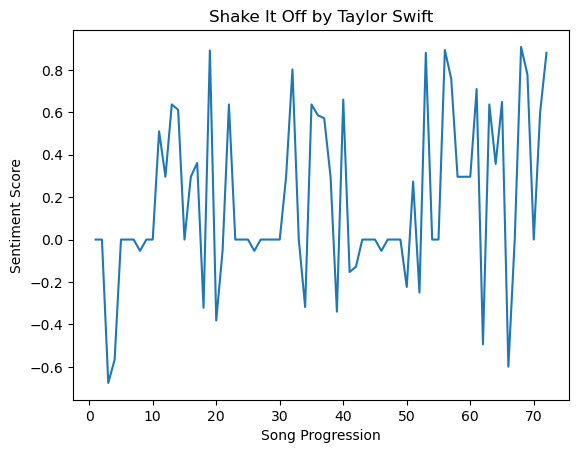

'sentiment_plot.png'

In [696]:
sentimentViz(sentimentResults, artistName, songTitle, filename="sentiment_plot.png")

Searching for "Halocene" by Bon Iver...
Done.


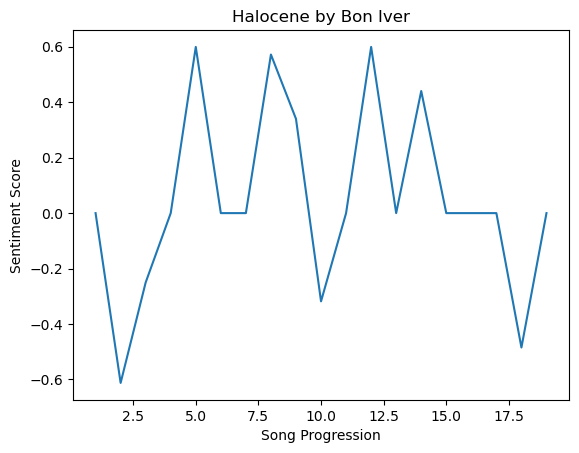

'sentiment_plot.png'

In [700]:
artistName = "Bon Iver"
songTitle = "Halocene"
lyrics = getLyrics(artistName, songTitle)

sentimentResults = analyzeLyrics(lyrics)

sentimentViz(sentimentResults, artistName, songTitle)

Searching for "Lump Sum" by Bon Iver...
Done.


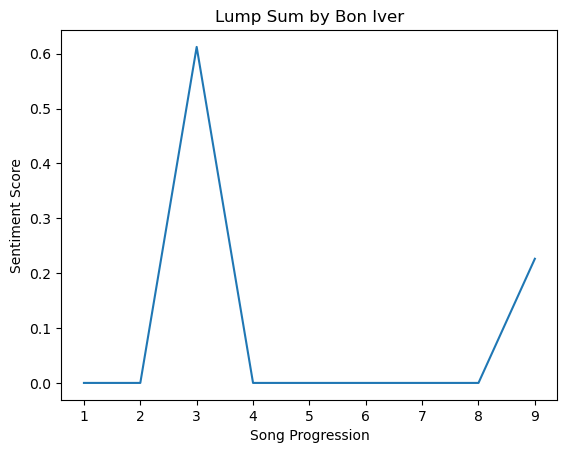

'sentiment_plot.png'

In [726]:
artistName = "Bon Iver"
songTitle = "Lump Sum"
lyrics = getLyrics(artistName, songTitle)

sentimentResults = analyzeLyrics(lyrics)

sentimentViz(sentimentResults, artistName, songTitle)

In [ ]:
#numbers at bottom is in chunks 

In [713]:
artistName = "Bon Iver"
songTitle = "Lump Sum"
song = getLyrics(artistName, songTitle)

Searching for "Lump Sum" by Bon Iver...
Done.


In [717]:
words = song.split()

In [719]:
len(words)

89

In [730]:
89/10

8.9

In [732]:
round(8.9)

9

In [734]:
#there she is